# Overview: determine a correlation between baseball salary and various metrics, specifically regarding correlation between advanced metrics and simple metrics for salary prediction

Process expectation:

    1 - Build database storage for historical database
        a - master storage in sqlite
        b - year by year storage in csv, then batch update master storage

    2 - Scrape using Selenium
        a - learning Selenium over requests + bs4
        b - baseball-reference.com for stats including salary database

    3 - Build stats and analytics
        a - specifics to come later
        

In [17]:
# Configuration and setup - RUN THIS FIRST

# Imports
from playerData import PlayerData
from sqlite3 import connect
from playerData import (
        Summary, StandardBatting, AdvancedBatting, ValueBatting,
        StandardPitching, AdvancedPitching, ValuePitching,
        StandardFielding, SalaryEntry
    )
from collections import deque

# Globals
DB_NAME = 'database.db'
SCRAPES_PER_MINUTE = 20
START_YEAR = 1990
END_YEAR = 2024
CSV_LOCATION = 'data'
REQUEST_TIMES = deque(maxlen=20)  # store the timestamps of the last 20 requests
RESUME_PLAYER = 'sackibr01'  # id or None
RESUME_FLAG = RESUME_PLAYER is None

# Selenium config
HEADLESS = False
DRIVER_LOCATION = 'chromedriver.exe'

# Setup
conn = connect(DB_NAME)

In [2]:
# Selenium initialization
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options

chrome_options = Options()
if HEADLESS:
    chrome_options.add_argument("--headless")  # optional for headless mode
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                            "AppleWebKit/537.36 (KHTML, like Gecko) "
                            "Chrome/115.0.0.0 Safari/537.36")
chrome_options.add_argument("--blink-settings=imagesEnabled=false")
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--window-size=1000,720")

DRIVER = webdriver.Chrome(service=Service(DRIVER_LOCATION),
                          options=chrome_options)

# Quick test
DRIVER.get("https://www.google.com")
print(DRIVER.title)
DRIVER.quit()


Google


In [3]:
# Building the database

from sqlite3 import Connection

def initialize_database(conn: Connection):
    create_summary_table(conn)
    create_standard_batting_table(conn)
    create_advanced_batting_table(conn)
    create_value_batting_table(conn)
    create_standard_pitching_table(conn)
    create_advanced_pitching_table(conn)
    create_value_pitching_table(conn)
    create_standard_fielding_table(conn)
    create_salary_table(conn)
    create_play_years_table(conn)


def create_table_from_contract(conn: Connection, name: str, columns: dict[str, str]):
    table_string = f'CREATE TABLE IF NOT EXISTS {name} ('

    for key in columns:
        table_string += f'\n{key} {columns[key]},'
    
    # drop last comma and close
    table_string = table_string[:-1]
    table_string += ');'
    
    cursor = conn.cursor()
    cursor.execute(table_string)
    cursor.close()

def create_summary_table(conn:Connection):
    
    table_dict = {
            "composite_id": "TEXT PRIMARY KEY",
            "first_name": "TEXT",
            "last_name": "TEXT",
            "team": "TEXT",
            "league": "TEXT",
            "bats": "TEXT",
            "throws": "TEXT",
            "height_inches": "INTEGER",
            "weight_lbs": "INTEGER",
            "recent_headshot": "BLOB",
            "birthday": "TEXT",
            "hometown": "TEXT",
            "awards": "TEXT"
        }
    
    create_table_from_contract(conn, 'summary', table_dict)

def create_standard_batting_table(conn:Connection):
    
    table_dict = {
            "composite_id": "TEXT PRIMARY KEY",
            "wins_above_replacement": "REAL",
            "games": "INTEGER",
            "plate_appearances": "INTEGER",
            "at_bats": "INTEGER",
            "runs_scored": "INTEGER",
            "hits": "INTEGER",
            "doubles": "INTEGER",
            "triples": "INTEGER",
            "home_runs": "INTEGER",
            "runs_batted_in": "INTEGER",
            "stolen_bases": "INTEGER",
            "caught_stealing": "INTEGER",
            "walks": "INTEGER",
            "strike_outs": "INTEGER",
            "batting_average": "REAL",
            "on_base_percentage": "REAL",
            "slugging": "REAL",
            "ops": "REAL",
            "ops_plus": "REAL",
            "roba": "REAL",
            "rbat_plus": "REAL",
            "total_bases": "INTEGER",
            "grounded_into_double_plays": "INTEGER",
            "hit_by_pitch": "INTEGER",
            "sacrifice_bunts": "INTEGER",
            "sacrifice_flies": "INTEGER",
            "intentional_walks": "INTEGER",
            "position": "TEXT",
        }
    
    create_table_from_contract(conn, 'standard_batting', table_dict)

def create_advanced_batting_table(conn:Connection):

    table_dict = {

            "composite_id": "TEXT PRIMARY KEY",
            "babip": "REAL",
            "iso": "REAL",
            "hr_pct": "REAL",
            "so_pct": "REAL",
            "bb_pct": "REAL",
            "ev": "REAL",
            "hard_hit_pct": "REAL",
            "ld_pct": "REAL",
            "gb_pct": "REAL",
            "fb_pct": "REAL",
            "gb_fb_ratio": "REAL",
            "pull_pct": "REAL",
            "center_pct": "REAL",
            "oppo_pct": "REAL",
            "wpa": "REAL",
            "cwpa": "REAL",
            "re24": "REAL",
            "rs_pct": "REAL",
            "sb_pct": "REAL",
            "xbt_pct": "REAL",
        }
    
    create_table_from_contract(conn, 'advanced_batting', table_dict)    

def create_value_batting_table(conn:Connection):
    
    table_dict = {"composite_id": "TEXT PRIMARY KEY",          # unique player ID
            "PA": "REAL",                     # plate appearances
            "Rbat": "REAL",                   # runs from batting
            "Rbaser": "REAL",                 # runs from baserunning
            "Rdp": "REAL",                     # runs lost to double plays
            "Rfield": "REAL",                 # runs from fielding
            "Rpos": "REAL",                    # positional adjustment runs
            "RAA": "REAL",                     # runs above average
            "WAA": "REAL",                     # wins above average
            "Rrep": "REAL",                    # replacement runs
            "RAR": "REAL",                      # runs above replacement
            "WAR": "REAL",                      # wins above replacement
            "waa_wl_pct": "REAL",              # WAA WL%
            "wl_162": "REAL",                  # 162WL%
            "oWAR": "REAL",                     # offensive WAR
            "dWAR": "REAL",                     # defensive WAR
            "oRAR": "REAL",                     # offensive RAR
        }
    
    create_table_from_contract(conn, 'value_batting', table_dict)  

def create_standard_pitching_table(conn:Connection):
    table_dict = {
            "composite_id": "TEXT PRIMARY KEY",
            "wins": "INTEGER",
            "losses": "INTEGER",
            "win_loss_pct": "REAL",
            "era": "REAL",
            "games": "INTEGER",
            "games_started": "INTEGER",
            "games_finished": "INTEGER",
            "complete_games": "INTEGER",
            "shutouts": "INTEGER",
            "saves": "INTEGER",
            "innings_pitched": "REAL",
            "hits_allowed": "INTEGER",
            "runs_allowed": "INTEGER",
            "earned_runs": "INTEGER",
            "home_runs_allowed": "INTEGER",
            "walks": "INTEGER",
            "intentional_walks": "INTEGER",
            "strike_outs": "INTEGER",
            "hit_by_pitch": "INTEGER",
            "balks": "INTEGER",
            "wild_pitches": "INTEGER",
            "batters_faced": "INTEGER",
            "era_plus": "REAL",
            "fip": "REAL",
            "whip": "REAL",
            "hits_per_9": "REAL",
            "hr_per_9": "REAL",
            "bb_per_9": "REAL",
            "so_per_9": "REAL",
            "so_to_bb": "REAL",
    }
    
    create_table_from_contract(conn, 'standard_pitching', table_dict)  

def create_advanced_pitching_table(conn:Connection):
    table_dict = {
            "composite_id": "TEXT PRIMARY KEY",
            "innings_pitched": "REAL",       # IP
            "batting_average": "REAL",       # BA
            "on_base_percentage": "REAL",    # OBP
            "slugging": "REAL",              # SLG
            "ops": "REAL",                   # OPS
            "babip": "REAL",                 # BAbip
            "hr_pct": "REAL",                # HR%
            "k_pct": "REAL",                 # K%
            "bb_pct": "REAL",                # BB%
            "exit_velocity": "REAL",         # EV
            "hard_hit_pct": "REAL",          # HardH%
            "ld_pct": "REAL",                # LD%
            "gb_pct": "REAL",                # GB%
            "fb_pct": "REAL",                # FB%
            "gb_fb_ratio": "REAL",           # GB/FB
            "wpa": "REAL",                   # WPA
            "cwpa": "REAL",                  # cWPA
            "re24": "REAL",                  # RE24
        }
    create_table_from_contract(conn, 'advanced_pitching', table_dict)  

def create_value_pitching_table(conn:Connection):
    table_dict = {
            "composite_id": "TEXT PRIMARY KEY",
            "innings_pitched": "REAL",       # IP
            "games": "INTEGER",              # G
            "games_started": "INTEGER",      # GS
            "runs_allowed": "INTEGER",       # R
            "ra9": "REAL",                   # RA9
            "ra9_opponent": "REAL",          # RA9opp
            "ra9_defense": "REAL",           # RA9def
            "ra9_role": "REAL",              # RA9role
            "ra9_extras": "REAL",            # RA9extras
            "ppfp": "REAL",                  # PPFp
            "ra9_avg": "REAL",               # RA9avg
            "raa": "REAL",                    # RAA
            "waa": "REAL",                    # WAA
            "waa_adj": "REAL",                # WAAadj
            "war": "REAL",                    # WAR
            "rar": "REAL",                    # RAR
            "waa_wl_pct": "REAL",             # WAA WL%
            "wl_162": "REAL",                 # 162WL%
        }
    
    create_table_from_contract(conn, 'value_pitching', table_dict)  

def create_standard_fielding_table(conn:Connection):
    table_dict = {
            "composite_id": "TEXT PRIMARY KEY",
            "position": "TEXT",                  # Pos
            "games": "INTEGER",                  # G
            "games_started": "INTEGER",          # GS
            "complete_games": "INTEGER",         # CG
            "innings": "REAL",                   # Inn
            "chances": "INTEGER",                # Ch
            "putouts": "INTEGER",                # PO
            "assists": "INTEGER",                # A
            "errors": "INTEGER",                 # E
            "double_plays": "INTEGER",           # DP
            "fielding_percentage": "REAL",       # Fld%
            "league_fielding_percentage": "REAL",# lgFld%
            "total_zone_total": "REAL",          # Rtot
            "total_zone_per_year": "REAL",       # Rtot/yr
            "defensive_runs_saved": "REAL",      # Rdrs
            "defensive_runs_saved_per_year": "REAL", # Rdrs/yr
            "range_factor_per_9": "REAL",        # RF/9
            "league_range_factor_per_9": "REAL", # lgRF9
            "range_factor_per_game": "REAL",     # RF/G
            "league_range_factor_per_game": "REAL", # lgRFG
            "stolen_bases_allowed": "INTEGER",   # SB
            "caught_stealing": "INTEGER",        # CS
            "caught_stealing_percentage": "REAL",# CS%
            "league_caught_stealing_percentage": "REAL", # lgCS%
            "pickoffs": "INTEGER",               # Pick
        }
    
    create_table_from_contract(conn, 'standard_fielding', table_dict)  

def create_salary_table(conn:Connection):
    table_dict = {
            "composite_id": "TEXT PRIMARY KEY",
            "year": "INTEGER",    # Year
            "salary": "REAL",     # Salary
        }
    
    create_table_from_contract(conn, 'salary', table_dict)  

def create_play_years_table(conn:Connection):
    query = '''CREATE TABLE IF NOT EXISTS player_years (
    composite_id TEXT NOT NULL,
    year INTEGER NOT NULL,
    hall_of_fame INTEGER,
    PRIMARY KEY (composite_id, year)
    );'''
    
    conn.execute(query)

initialize_database(conn)

In [6]:
# Playing years scraping

import sqlite3
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from collections import deque
from datetime import datetime
import time

def wait_for_rate_limit(request_times: deque, limit: int = 20, interval: int = 60):
    now = datetime.now()
    if len(request_times) == limit:
        oldest = request_times[0]
        elapsed = (now - oldest).total_seconds()
        if elapsed < interval:
            print('Waiting')
            time.sleep(interval - elapsed)
            print('Wait complete')
    request_times.append(datetime.now())

def insert_players_years_played(conn: sqlite3.Connection, player_data: list[dict]):
    query = """
    INSERT OR IGNORE INTO player_years (composite_id, year, hall_of_fame)
    VALUES (:composite_id, :year, :hall_of_fame)
    """
    conn.executemany(query, player_data)
    conn.commit()

def process_page(letter: str):
    def pull_composite_id(url: str):
        return url.rsplit('/', 1)[-1].split('.')[0]
    
    def pull_years_and_hof(text: str):
        hall_of_fame = 1 if '+' in text else 0
        years = text.replace('+', '').split('(')[1].rstrip(')')
        first_year, last_year = map(int, years.split('-'))
        return hall_of_fame, first_year, last_year
    
    DRIVER.get(f'https://www.baseball-reference.com/players/{letter}/')
    players_div = WebDriverWait(DRIVER, 10, poll_frequency=0.25).until(
    EC.presence_of_element_located((By.ID, "div_players_"))
)
    player_paragraphs = players_div.find_elements(By.TAG_NAME, "p")

    all_data = []

    for p in player_paragraphs:
        link = p.find_element(By.TAG_NAME, "a").get_attribute("href")
        if not link: # this should never happen
            raise ValueError("Expecting href and found none")
        composite_id = pull_composite_id(link)

        text = p.text
        hall_of_fame, first_year, last_year = pull_years_and_hof(text)

        data = [
            {'composite_id': composite_id,
             'year': year,
             'hall_of_fame': hall_of_fame}
            for year in range(first_year, last_year + 1)
        ]
        all_data.extend(data)

    insert_players_years_played(conn, all_data)


request_times = deque(maxlen=20)  # store the timestamps of the last 20 requests
alphabet = list("abcdefghijklmnopqrstuvwxyz")
for letter in alphabet:
    print(f"Scraping {letter}")
    wait_for_rate_limit(request_times, SCRAPES_PER_MINUTE)
    process_page(letter)
    print(f"Scraping {letter} complete")

DRIVER.quit()
    


Scraping a


KeyboardInterrupt: 

In [ ]:
# Batch storage creation

import csv
from dataclasses import fields
from pathlib import Path

def write_table_headers_to_csv(output_dir):
    table_classes = {
        "summary": Summary,
        "standard_batting": StandardBatting,
        "advanced_batting": AdvancedBatting,
        "value_batting": ValueBatting,
        "standard_pitching": StandardPitching,
        "advanced_pitching": AdvancedPitching,
        "value_pitching": ValuePitching,
        "standard_fielding": StandardFielding,
        "salary_history": SalaryEntry,
    }

    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    for table_name, cls in table_classes.items():
        csv_file = output_path / f"{table_name}.csv"

        if csv_file.exists():
            print(f"Skipped {table_name}, file already exists: {csv_file}")
            continue

        header_fields = [f.name for f in fields(cls)]
        
        with open(csv_file, mode="w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(header_fields)
        
        print(f"Wrote headers for {table_name} to {csv_file}")

for year in range(START_YEAR, END_YEAR + 1):
    write_table_headers_to_csv(f'data/{year}')

Wrote headers for summary to data\1990\summary.csv
Wrote headers for standard_batting to data\1990\standard_batting.csv
Wrote headers for advanced_batting to data\1990\advanced_batting.csv
Wrote headers for value_batting to data\1990\value_batting.csv
Wrote headers for standard_pitching to data\1990\standard_pitching.csv
Wrote headers for advanced_pitching to data\1990\advanced_pitching.csv
Wrote headers for value_pitching to data\1990\value_pitching.csv
Wrote headers for standard_fielding to data\1990\standard_fielding.csv
Wrote headers for salary_history to data\1990\salary_history.csv
Wrote headers for summary to data\1991\summary.csv
Wrote headers for standard_batting to data\1991\standard_batting.csv
Wrote headers for advanced_batting to data\1991\advanced_batting.csv
Wrote headers for value_batting to data\1991\value_batting.csv
Wrote headers for standard_pitching to data\1991\standard_pitching.csv
Wrote headers for advanced_pitching to data\1991\advanced_pitching.csv
Wrote heade

In [3]:
# Detail Scraping 

import playerData
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from typing import Optional
import re
from datetime import datetime
import time
from collections import deque
import csv
from pathlib import Path
from typing import Union
from dataclasses import asdict
from requests.exceptions import ReadTimeout
from urllib3.exceptions import ReadTimeoutError
from selenium.common.exceptions import TimeoutException, WebDriverException

driver = webdriver.Chrome(service=Service(DRIVER_LOCATION),
                          options=chrome_options)

def wait_for_rate_limit(request_times: deque, limit: int = 20, interval: int = 60):
    now = datetime.now()
    if len(request_times) == limit:
        oldest = request_times[0]
        elapsed = (now - oldest).total_seconds()
        if elapsed < interval:
            print('Waiting')
            time.sleep(interval - elapsed)
            print('Wait complete')
    request_times.append(datetime.now())

def scrape_player_given_year(baseball_ref_id: str, year: int): 
    def parse_birthdate(born_text):
        if not born_text:
            return None
        
        born_text = born_text.split('(')[0][:-1]

        try:
            date_obj = datetime.strptime(born_text, "%B %d, %Y")
            return date_obj.strftime("%Y-%m-%d")
        except ValueError:
            # Could not parse date
            return None
        
    def _height_to_inches(h_text: str) -> Optional[int]:
        # Accepts formats like "6-3" or "6' 3\"" (B-R uses 6-3)
        if not h_text:
            return None
        m = re.search(r'(\d+)\s*[-\'ft]\s*(\d+)', h_text)
        if not m:
            # fallback: just feet (e.g., "6-0" sometimes omitted inches visually)
            m2 = re.search(r'(\d+)\s*(?:ft|\'|-)\s*$', h_text)
            if m2:
                return int(m2.group(1)) * 12
            return None
        feet, inches = int(m.group(1)), int(m.group(2))
        return feet * 12 + inches
    
    def scrape_summary() -> playerData.Summary: # Also waits for page to load. Please don't wait again
        WebDriverWait(driver, 10, poll_frequency=0.25).until(EC.presence_of_element_located((By.ID, "info")))

        # Team and league
        try:
            batting = driver.find_element(By.ID, f"players_standard_batting.{year}")
            team = batting.find_element(By.CSS_SELECTOR, 'td[data-stat="team_name_abbr"] a').text
            league = batting.find_element(By.CSS_SELECTOR, 'td[data-stat="comp_name_abbr"] a').text
            awards_elem = batting.find_elements(By.CSS_SELECTOR, 'td[data-stat="awards"] a')
            awards = awards_elem[0].text if awards_elem else None
        except NoSuchElementException:
            pitching = driver.find_element(By.ID, f"players_standard_pitching.{year}")
            team = pitching.find_element(By.CSS_SELECTOR, 'td[data-stat="team_name_abbr"] a').text
            league = pitching.find_element(By.CSS_SELECTOR, 'td[data-stat="comp_name_abbr"] a').text
            awards_elem = pitching.find_elements(By.CSS_SELECTOR, 'td[data-stat="awards"] a')
            awards = awards_elem[0].text if awards_elem else None

        # Grab the whole block
        info_div = driver.find_element(By.ID, "info")
        info_text = info_div.text  # single DOM traversal

        # Name
        first_name = info_text.split(' ', 1)[0].strip()
        last_name = info_text.split(' ', 2)[1].split('\n')[0]

        # Bats and Throws
        bat_match = re.search(r'Bats:\s*(\w+)', info_text)
        throw_match = re.search(r'Throws:\s*(\w+)', info_text)
        batting_hand = bat_match.group(1) if bat_match else None
        throwing_hand = throw_match.group(1) if throw_match else None

        # Height and Weight
        height_match = re.search(r'(\d+-\d+)', info_text)
        weight_match = re.search(r'(\d+)lb', info_text)
        height_inches = _height_to_inches(height_match.group(1)) if height_match else None
        weight_lbs = int(weight_match.group(1)) if weight_match else None

        # Birthday
        birthday_match = re.search(r'Born:\s*(.+)', info_text)
        birthday = parse_birthdate(birthday_match.group(1)) if birthday_match else None

        # Hometown
        hometown_match = re.search(r'in (.*)\n', info_text)
        hometown = hometown_match.group(1) if hometown_match else None # Oshu, Japan jp

        return Summary(composite_id, first_name, last_name, team, league, batting_hand, throwing_hand, height_inches, weight_lbs, None, birthday, hometown, awards)

    def scrape_standard_batting() -> playerData.StandardBatting:

        row = driver.find_element(By.ID, f"players_standard_batting.{year}")
        cells = row.find_elements(By.TAG_NAME, "td")

        # Map data-stat values to class attributes
        mapping = {
            "b_war": "wins_above_replacement",
            "b_games": "games",
            "b_pa": "plate_appearances",
            "b_ab": "at_bats",
            "b_r": "runs_scored",
            "b_h": "hits",
            "b_doubles": "doubles",
            "b_triples": "triples",
            "b_hr": "home_runs",
            "b_rbi": "runs_batted_in",
            "b_sb": "stolen_bases",
            "b_cs": "caught_stealing",
            "b_bb": "walks",
            "b_so": "strike_outs",
            "b_batting_avg": "batting_average",
            "b_onbase_perc": "on_base_percentage",
            "b_slugging_perc": "slugging",
            "b_onbase_plus_slugging": "ops",
            "b_onbase_plus_slugging_plus": "ops_plus",
            "b_roba": "roba",
            "b_rbat_plus": "rbat_plus",
            "b_tb": "total_bases",
            "b_gidp": "grounded_into_double_plays",
            "b_hbp": "hit_by_pitch",
            "b_sh": "sacrifice_bunts",
            "b_sf": "sacrifice_flies",
            "b_ibb": "intentional_walks",
            "pos": "position"
        }

        sb = StandardBatting(composite_id=f"{baseball_ref_id}_{year}")

        for cell in cells:
            key = cell.get_attribute("data-stat")
            if key in mapping:
                attr = mapping[key]
                text = cell.text.strip()

                # Convert types based on field
                if text == "":
                    value = None
                elif attr in {"batting_average", "on_base_percentage", "slugging", "ops", "roba"}:
                    value = float(text)
                elif attr in {"wins_above_replacement", "rbat_plus"}:
                    value = float(text)
                elif attr in {"ops_plus"}:
                    value = int(text)
                elif attr == "position":
                    value = text
                else:
                    value = int(text)

                setattr(sb, attr, value)

        return sb   
    
    def scrape_value_batting():
        row = driver.find_element(By.ID, f"players_value_batting.{year}")
        cells = row.find_elements(By.TAG_NAME, "td")

        mapping = {
            "b_pa": "PA",
            "b_runs_batting": "Rbat",
            "b_runs_baserunning": "Rbaser",
            "b_runs_double_plays": "Rdp",
            "b_runs_fielding": "Rfield",
            "b_runs_position": "Rpos",
            "b_raa": "RAA",
            "b_waa": "WAA",
            "b_runs_replacement": "Rrep",
            "b_rar": "RAR",
            "b_war": "WAR",
            "b_waa_win_perc": "waa_wl_pct",
            "b_waa_win_perc_162": "wl_162",
            "b_war_off": "oWAR",
            "b_war_def": "dWAR",
            "b_rar_off": "oRAR",
        }

        vb = ValueBatting(composite_id=f"{baseball_ref_id}_{year}")

        for cell in cells:
            key = cell.get_attribute("data-stat")
            if key not in mapping:
                continue

            attr = mapping[key]
            text = cell.text.strip()

            if text == "":
                value = None
            else:
                match attr:
                    case "waa_wl_pct" | "wl_162":
                        value = float(text)
                    case _:
                        value = float(text)

            setattr(vb, attr, value)

        return vb
    
    def scrape_advanced_batting():
        row = driver.find_element(By.ID, f"players_advanced_batting.{year}")
        cells = row.find_elements(By.TAG_NAME, "td")

        mapping = {
            "b_batting_avg_bip": "babip",
            "b_iso_slugging": "iso",
            "b_home_run_perc": "hr_pct",
            "b_strikeout_perc": "so_pct",
            "b_base_on_balls_perc": "bb_pct",
            "b_avg_exit_velo": "ev",
            "b_hard_hit_perc": "hard_hit_pct",
            "b_ld_perc": "ld_pct",
            "b_gb_perc": "gb_pct",
            "b_fb_perc": "fb_pct",
            "b_gb_fb_ratio": "gb_fb_ratio",
            "b_pull_perc": "pull_pct",
            "b_center_perc": "center_pct",
            "b_oppo_perc": "oppo_pct",
            "b_wpa_bat": "wpa",
            "b_cwpa_bat": "cwpa",
            "b_baseout_runs": "re24",
            "b_run_scoring_perc": "rs_pct",
            "b_stolen_base_perc": "sb_pct",
            "b_extra_bases_taken_perc": "xbt_pct",
        }

        ab = AdvancedBatting(composite_id=f"{baseball_ref_id}_{year}")

        for cell in cells:
            key = cell.get_attribute("data-stat")
            if key not in mapping:
                continue

            attr = mapping[key]
            text = cell.text.strip()

            if text == "":
                value = None
            else:
                # All AdvancedBatting fields are floats
                try:
                    value = float(text.strip("%")) if text.endswith("%") else float(text)
                except ValueError:
                    value = None

            setattr(ab, attr, value)

        return ab
        
    def scrape_standard_pitching():
        row = driver.find_element(By.ID, f"players_standard_pitching.{year}")
        cells = row.find_elements(By.TAG_NAME, "td")

        mapping = {
            "p_w": "wins",
            "p_l": "losses",
            "p_win_loss_perc": "win_loss_pct",
            "p_earned_run_avg": "era",
            "p_g": "games",
            "p_gs": "games_started",
            "p_gf": "games_finished",
            "p_cg": "complete_games",
            "p_sho": "shutouts",
            "p_sv": "saves",
            "p_ip": "innings_pitched",
            "p_h": "hits_allowed",
            "p_r": "runs_allowed",
            "p_er": "earned_runs",
            "p_hr": "home_runs_allowed",
            "p_bb": "walks",
            "p_ibb": "intentional_walks",
            "p_so": "strike_outs",
            "p_hbp": "hit_by_pitch",
            "p_bk": "balks",
            "p_wp": "wild_pitches",
            "p_bfp": "batters_faced",
            "p_earned_run_avg_plus": "era_plus",
            "p_fip": "fip",
            "p_whip": "whip",
            "p_hits_per_nine": "hits_per_9",
            "p_hr_per_nine": "hr_per_9",
            "p_bb_per_nine": "bb_per_9",
            "p_so_per_nine": "so_per_9",
            "p_strikeouts_per_base_on_balls": "so_to_bb"
        }

        sp = StandardPitching(composite_id=f"{baseball_ref_id}_{year}")

        for cell in cells:
            key = cell.get_attribute("data-stat")
            if key not in mapping:
                continue
            attr = mapping[key]
            text = cell.text.strip()

            if text in {"", "iz"}:  # "iz" cells are zero visually
                value = 0 if attr not in {"era", "era_plus", "fip", "whip", "win_loss_pct", "so_to_bb", "innings_pitched"} else 0.0
            else:
                # Determine type
                if attr in {"era", "era_plus", "fip", "whip", "win_loss_pct", "so_to_bb", "innings_pitched", "hits_per_9", "hr_per_9", "bb_per_9", "so_per_9"}:
                    value = float(text)
                else:
                    value = int(text)
            setattr(sp, attr, value)

        return sp

    def scrape_advanced_pitching():

        composite_id = f"{baseball_ref_id}_{year}"
    
        # Locate the row for advanced pitching
        row = driver.find_element(By.ID, f"players_advanced_pitching.{year}")
        cells = row.find_elements(By.TAG_NAME, "td")

        # Mapping from HTML data-stat to AdvancedPitching attributes
        mapping = {
            "p_ip": "innings_pitched",
            "p_batting_avg": "batting_average",
            "p_onbase_perc": "on_base_percentage",
            "p_slugging_perc": "slugging",
            "p_ops": "ops",
            "p_babip": "babip",
            "p_home_run_perc": "hr_pct",
            "p_strikeout_perc": "k_pct",
            "p_base_on_balls_perc": "bb_pct",
            "p_avg_exit_velo": "exit_velocity",
            "p_hard_hit_perc": "hard_hit_pct",
            "p_ld_perc": "ld_pct",
            "p_gb_perc": "gb_pct",
            "p_fb_perc": "fb_pct",
            "p_gb_fb_ratio": "gb_fb_ratio",
            "p_wpa_def": "wpa",
            "p_cwpa_def": "cwpa",
            "p_baseout_runs": "re24",
        }

        ap = AdvancedPitching(composite_id=composite_id)

        for cell in cells:
            key = cell.get_attribute("data-stat")
            if key not in mapping:
                continue
            attr = mapping[key]
            text = cell.text.strip()
            if not text or text == "—":
                value = None
            else:
                try:
                    # Remove '%' if present, then convert to float
                    value = float(text.strip("%"))
                except ValueError:
                    value = None
            setattr(ap, attr, value)

        return ap
    
    def scrape_value_pitching():
        row = driver.find_element(By.ID, f"players_value_pitching.{year}")
        cells = row.find_elements(By.TAG_NAME, "td")

        mapping = {
            "p_ip": "innings_pitched",
            "p_g": "games",
            "p_gs": "games_started",
            "p_r": "runs_allowed",
            "p_ra9": "ra9",
            "p_ra9_opp": "ra9_opponent",
            "p_ra9_def": "ra9_defense",
            "p_ra9_role": "ra9_role",
            "p_ra9_extras": "ra9_extras",
            "p_ppf_custom": "ppfp",
            "p_ra9_avg_pitcher": "ra9_avg",
            "p_raa": "raa",
            "p_waa": "waa",
            "p_waa_adj": "waa_adj",
            "p_war": "war",
            "p_rar": "rar",
            "p_waa_win_perc": "waa_wl_pct",
            "p_waa_win_perc_162": "wl_162",
        }

        vp = ValuePitching(composite_id=f"{baseball_ref_id}_{year}")

        for cell in cells:
            key = cell.get_attribute("data-stat")
            if key not in mapping:
                continue

            attr = mapping[key]
            text = cell.text.strip()

            if not text or text == "—":
                value = None
            else:
                try:
                    # Some fields are percentages with a "%" suffix
                    value = float(text.strip("%")) if text.endswith("%") else float(text)
                except ValueError:
                    value = None

            setattr(vp, attr, value)

        return vp

    def scrape_standard_fielding():
        sf = StandardFielding(composite_id=f"{baseball_ref_id}_{year}")

    
        rows = driver.find_elements(By.ID, f"players_standard_fielding.{year}")
        # Mapping of table data-stat to dataclass attribute
        mapping = {
            "f_position": "position",
            "f_games": "games",
            "f_games_started": "games_started",
            "f_cg": "complete_games",
            "f_innings": "innings",
            "f_chances": "chances",
            "f_po": "putouts",
            "f_assists": "assists",
            "f_errors": "errors",
            "f_dp": "double_plays",
            "f_fielding_perc": "fielding_percentage",
            "f_fielding_perc_lg": "league_fielding_percentage",
            "f_tz_runs_total": "total_zone_total",
            "f_tz_runs_total_per_year": "total_zone_per_year",
            "f_drs_total": "defensive_runs_saved",
            "f_drs_total_per_year": "defensive_runs_saved_per_year",
            "f_range_factor_per_nine": "range_factor_per_9",
            "f_range_factor_per_nine_lg": "league_range_factor_per_9",
            "f_range_factor_per_game": "range_factor_per_game",
            "f_range_factor_per_game_lg": "league_range_factor_per_game",
            "f_sb": "stolen_bases_allowed",
            "f_cs": "caught_stealing",
            "f_cs_perc": "caught_stealing_percentage",
            "f_cs_perc_lg": "league_caught_stealing_percentage",
            "f_pickoffs": "pickoffs",
        }

        float_fields = {
            "innings", "fielding_percentage", "league_fielding_percentage",
            "total_zone_total", "total_zone_per_year", "defensive_runs_saved",
            "defensive_runs_saved_per_year", "range_factor_per_9",
            "league_range_factor_per_9", "range_factor_per_game",
            "league_range_factor_per_game", "caught_stealing_percentage",
            "league_caught_stealing_percentage",
        }

        # Fields to sum across positions
        numeric_fields = {
            "games", "games_started", "complete_games", "innings", "chances",
            "putouts", "assists", "errors", "double_plays", "total_zone_total",
            "total_zone_per_year", "defensive_runs_saved",
            "defensive_runs_saved_per_year", "stolen_bases_allowed",
            "caught_stealing", "pickoffs"
        }

        # Temporary totals for weighted averages
        total_chances = 0
        total_innings = 0
        total_cs_attempts = 0

        for row in rows:
            cells = row.find_elements(By.TAG_NAME, "td")
            row_data = {}

            # Parse row data
            for cell in cells:
                key = cell.get_attribute("data-stat")
                if key not in mapping:
                    continue
                attr = mapping[key]

                csk = cell.get_attribute("csk")
                text = cell.text.strip().replace("\xa0", "")
                value = None

                if csk:
                    try:
                        value = float(csk) if attr in float_fields else int(float(csk))
                    except ValueError:
                        value = None
                elif text and text != "—":
                    try:
                        value = float(text) if attr in float_fields else int(text)
                    except ValueError:
                        value = None

                row_data[attr] = value

            # Sum numeric fields
            for attr in numeric_fields:
                existing = getattr(sf, attr) or 0
                setattr(sf, attr, existing + (row_data.get(attr) or 0))

            # Track totals for weighted averages
            row_chances = row_data.get("chances") or 0
            row_innings = row_data.get("innings") or 0
            sf_chances = row_data.get("chances") or 0
            sf_innings = row_data.get("innings") or 0
            total_chances += row_chances
            total_innings += row_innings

            cs_attempts = (row_data.get("caught_stealing") or 0) + (row_data.get("stolen_bases_allowed") or 0)
            total_cs_attempts += cs_attempts

            # Combine positions
            pos = row_data.get("position")
            if pos:
                if sf.position:
                    if pos not in sf.position.split("/"):
                        sf.position += f"/{pos}"
                else:
                    sf.position = pos

        # Calculate weighted averages
        if total_chances > 0:
            sf.fielding_percentage = (sf.putouts + sf.assists) / total_chances # type: ignore
        if total_innings > 0:
            sf.range_factor_per_9 = (sf.putouts + sf.assists) * 9 / total_innings # type: ignore
        if total_cs_attempts > 0:
            sf.caught_stealing_percentage = sf.caught_stealing / total_cs_attempts # type: ignore

        return sf

    def scrape_salary_history():
        row = driver.find_element(By.XPATH, f'//tr[th[@data-stat="year_ID" and text()="{year}"]]')
        # Year
        year_cell = row.find_element(By.CSS_SELECTOR, 'th[data-stat="year_ID"]')
        year_val = int(year_cell.text.strip()) if year_cell.text.strip().isdigit() else None

        # Salary
        salary_cell = row.find_element(By.CSS_SELECTOR, 'td[data-stat="Salary"]')
        salary_val = None
        if salary_cell:
            try:
                # Use the data-amount attribute for numeric value
                attr = salary_cell.get_attribute("data-amount")
                salary_val = float(attr) if attr is not None else None
            except (ValueError, TypeError):
                salary_val = None

        return SalaryEntry(composite_id=f"{baseball_ref_id}_{year}", year=year_val, salary=salary_val)

    composite_id = f'{baseball_ref_id}_{year}'

    page = f'https://www.baseball-reference.com/players/{baseball_ref_id[0]}/{baseball_ref_id}.shtml'
    driver.get(page)

    try:
        summary = scrape_summary()
    except NoSuchElementException:
        summary = Summary()

    try:
        standard_batting = scrape_standard_batting()
    except NoSuchElementException:
        standard_batting = StandardBatting()

    try:
        advanced_batting = scrape_advanced_batting()
    except NoSuchElementException:
        advanced_batting = AdvancedBatting()

    try:
        value_batting = scrape_value_batting()
    except NoSuchElementException:
        value_batting = ValueBatting()

    try:
        standard_pitching  = scrape_standard_pitching()
    except NoSuchElementException:
        standard_pitching = StandardPitching()

    try: 
        advanced_pitching = scrape_advanced_pitching()
    except NoSuchElementException:
        advanced_pitching = AdvancedPitching()
    
    try: 
        value_pitching = scrape_value_pitching()
    except NoSuchElementException:
        value_pitching = ValuePitching()

    try: 
        standard_fielding = scrape_standard_fielding()
    except NoSuchElementException:
        standard_fielding = StandardFielding()

    try: 
        salary_history = scrape_salary_history()
    except NoSuchElementException:
        salary_history = SalaryEntry()    

    return playerData.PlayerData(summary, standard_batting, advanced_batting, value_batting, standard_pitching, advanced_pitching, value_pitching, standard_fielding, salary_history)

def get_players_given_year(year: int) -> list[str]:
    sql = '''
    SELECT composite_id
    FROM player_years
    WHERE year = ?;
    '''

    cursor = conn.cursor()

    cursor.execute(sql, (year,))
    players = cursor.fetchall()
    return players

def write_playerdata_to_year_folder(player_data: PlayerData, year: int, base_folder: Union[str, Path]):
    """
    Write each sub-object of PlayerData to its respective CSV file in the year folder.
    If the CSV doesn't exist, headers are written first.
    """
    base_folder = Path(base_folder) / str(year)
    base_folder.mkdir(parents=True, exist_ok=True)

    # Map sub-object names to the attribute names
    sections = {
        "summary": player_data.summary,
        "standard_batting": player_data.standard_batting,
        "advanced_batting": player_data.advanced_batting,
        "value_batting": player_data.value_batting,
        "standard_pitching": player_data.standard_pitching,
        "advanced_pitching": player_data.advanced_pitching,
        "value_pitching": player_data.value_pitching,
        "standard_fielding": player_data.standard_fielding,
        "salary_history": player_data.salary_history,
    }

    for section_name, section_obj in sections.items():
        csv_path = base_folder / f"{section_name}.csv"
        row = {k: v for k, v in asdict(section_obj).items()}  # convert dataclass to dict

        file_exists = csv_path.exists()
        with open(csv_path, "a", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=row.keys())
            if not file_exists:
                writer.writeheader()
            writer.writerow(row)

for year in range(END_YEAR, START_YEAR- 1, -1): 
    print(f'Starting {year}')
    players = get_players_given_year(year)
    for (player_id,) in players:
        if not RESUME_FLAG: # type: ignore
            if player_id == RESUME_PLAYER:
                RESUME_FLAG = True  # start processing from here
            else:
                continue  # skip until we reach the target player

        did_work = False
        trials = 0
        while not did_work and trials <= 5:
            try:
                wait_for_rate_limit(REQUEST_TIMES, SCRAPES_PER_MINUTE)
                data = scrape_player_given_year(player_id, year)
                write_playerdata_to_year_folder(data, year, CSV_LOCATION)
                did_work = True
                print(f'Processed {player_id} for {year}')
            except (ReadTimeout, TimeoutException, WebDriverException, ReadTimeoutError) as e: # its gonna be one of them
                print(f"Uh oh. {e}. Trying again.")
                driver.quit()
                driver = webdriver.Chrome(service=Service(DRIVER_LOCATION),
                          options=chrome_options)
                time.sleep(2)
            trials += 1

        if not did_work:
            print(f"Failed to process {player_id} for {year} after 5 attempts.")

    print(f'Done {year}')


driver.quit()


Starting 1996
Processed sackibr01 for 1996
Processed saenzol01 for 1996
Uh oh. Message: 
Stacktrace:
	GetHandleVerifier [0x0x7ff6b4ec6b25+79621]
	GetHandleVerifier [0x0x7ff6b4ec6b80+79712]
	(No symbol) [0x0x7ff6b4c5c0ea]
	(No symbol) [0x0x7ff6b4cb2f56]
	(No symbol) [0x0x7ff6b4cb320c]
	(No symbol) [0x0x7ff6b4d065b7]
	(No symbol) [0x0x7ff6b4cdb17f]
	(No symbol) [0x0x7ff6b4d033d0]
	(No symbol) [0x0x7ff6b4cdaf13]
	(No symbol) [0x0x7ff6b4ca4151]
	(No symbol) [0x0x7ff6b4ca4ee3]
	GetHandleVerifier [0x0x7ff6b518683d+2962461]
	GetHandleVerifier [0x0x7ff6b5180b5d+2938685]
	GetHandleVerifier [0x0x7ff6b519f71d+3064573]
	GetHandleVerifier [0x0x7ff6b4ee0c6e+186446]
	GetHandleVerifier [0x0x7ff6b4ee8a3f+218655]
	GetHandleVerifier [0x0x7ff6b4ecf914+115956]
	GetHandleVerifier [0x0x7ff6b4ecfac9+116393]
	GetHandleVerifier [0x0x7ff6b4eb5ef8+10968]
	BaseThreadInitThunk [0x0x7ffde32fe8d7+23]
	RtlUserThreadStart [0x0x7ffde49e8d9c+44]
. Trying again.
Uh oh. Message: 
Stacktrace:
	GetHandleVerifier [0x0x7ff6b4e

In [4]:
# Commit to DB from CSV

import sqlite3
import csv
from pathlib import Path

# map CSV filenames to table names
csv_to_table = {
    "summary.csv": "summary",
    "standard_batting.csv": "standard_batting",
    "advanced_batting.csv": "advanced_batting",
    "value_batting.csv": "value_batting",
    "standard_pitching.csv": "standard_pitching",
    "advanced_pitching.csv": "advanced_pitching",
    "value_pitching.csv": "value_pitching",
    "standard_fielding.csv": "standard_fielding",
    "salary_history.csv": "salary", 
}

def insert_csv_to_table(csv_path: Path, table_name: str, conn: sqlite3.Connection, year: int | None = None):
    """Insert CSV rows into SQLite table, skipping empty rows."""
    with open(csv_path, newline='', encoding='utf-8-sig') as f:
        reader = csv.DictReader(f)
        if not reader.fieldnames:
            print(f"Skipping {csv_path}: no headers found.")
            return
        
        columns = [col.strip() for col in reader.fieldnames]

        # Only add 'year' column for salary table (or other tables that actually have 'year')
        if table_name == "salary" and 'year' not in columns and year is not None:
            columns.append('year')

        placeholders = ", ".join("?" for _ in columns)
        column_names = ", ".join(columns)
        sql = f"INSERT OR REPLACE INTO {table_name} ({column_names}) VALUES ({placeholders})"

        rows = []
        for row in reader:
            # Skip completely empty rows or rows without composite_id
            if not row.get('composite_id') or all(v.strip() == '' for v in row.values() if v):
                continue

            row_data = [row.get(col, None) if row.get(col, None) != '' else None for col in reader.fieldnames]

            if table_name == "salary" and 'year' not in reader.fieldnames and year is not None:
                row_data.append(year)

            rows.append(tuple(row_data))

        if rows:
            conn.executemany(sql, rows)
            conn.commit()
        print(f"Inserted {len(rows)} rows into {table_name} from {csv_path.name} for year {year}")



parent_folder = Path(CSV_LOCATION)

for year_folder in parent_folder.iterdir():
    if year_folder.is_dir() and year_folder.name.isdigit():
        year = int(year_folder.name)
        if not (START_YEAR <= year <= END_YEAR):
            continue

        for csv_file in year_folder.glob("*.csv"):
            table_name = csv_to_table.get(csv_file.name)
            if table_name:
                insert_csv_to_table(csv_file, table_name, conn, year)
            else:
                print(f"Skipping unknown CSV: {csv_file}")


Inserted 864 rows into advanced_batting from advanced_batting.csv for year 1990
Inserted 503 rows into advanced_pitching from advanced_pitching.csv for year 1990
Inserted 915 rows into salary from salary_history.csv for year 1990
Inserted 865 rows into standard_batting from standard_batting.csv for year 1990
Inserted 1092 rows into standard_fielding from standard_fielding.csv for year 1990
Inserted 503 rows into standard_pitching from standard_pitching.csv for year 1990
Inserted 959 rows into summary from summary.csv for year 1990
Inserted 865 rows into value_batting from value_batting.csv for year 1990
Inserted 503 rows into value_pitching from value_pitching.csv for year 1990
Inserted 857 rows into advanced_batting from advanced_batting.csv for year 1991
Inserted 494 rows into advanced_pitching from advanced_pitching.csv for year 1991
Inserted 681 rows into salary from salary_history.csv for year 1991
Inserted 857 rows into standard_batting from standard_batting.csv for year 1991
Ins

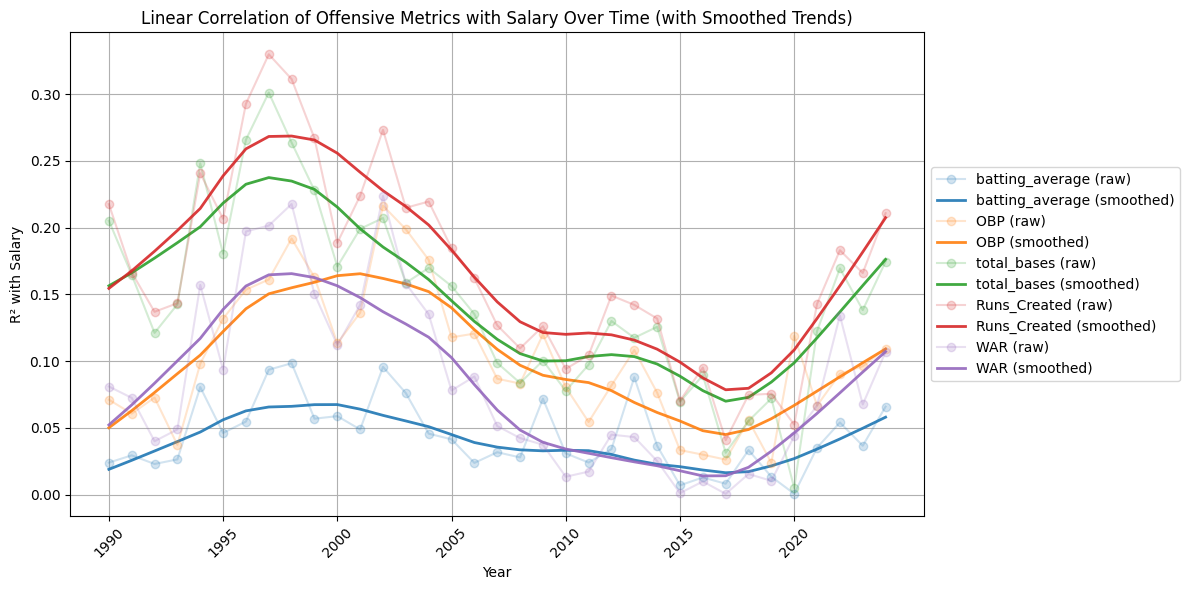

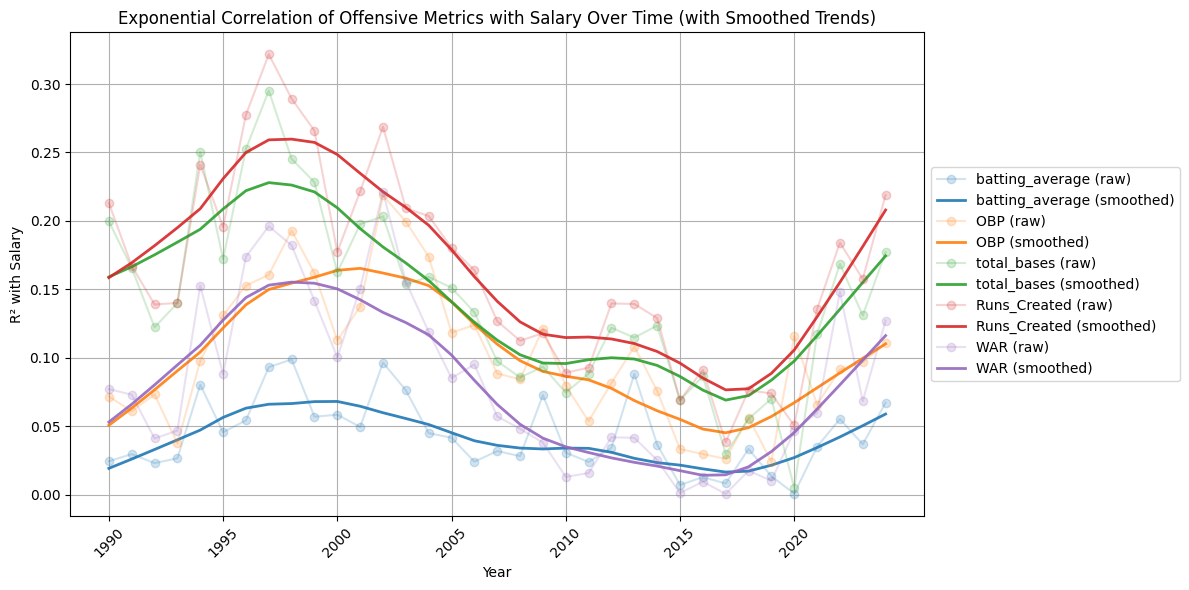

In [7]:
# Fundamental Analysis (Batters)

import numpy as np
import statsmodels.api as sm
import scipy.stats as sps
import scipy.optimize as spo
import matplotlib.pyplot as plt

def get_r_squared(salary_list: list[float], metric: list[float|int]) -> tuple[float, float]:
    "return (Linear_R^2, Exponential_R^2)"

    def exponential(x, a, b):
        return a * np.exp(b * x)
    
    if len(salary_list) != len(metric):
        raise ValueError("Expected lists to be of same size")
    
    salary_arr = np.array(salary_list) / 1_000_000  # scale salaries to millions
    metric_arr = np.array(metric)

    mask = (salary_arr != 0) & (metric_arr != 0) & (~np.isnan(metric_arr))
    x = salary_arr[mask]
    y = metric_arr[mask]

    # Linear r
    r_linear = sps.linregress(x, y).rvalue 

    # Exponential R^2
    popt, _ = spo.curve_fit(exponential, x, y, p0=(1, 0.01))
    y_pred_exp = exponential(x, *popt)
    ss_resid = np.sum((y - y_pred_exp)**2)
    ss_total = np.sum((y - np.mean(y))**2)
    r2_exp = 1 - ss_resid / ss_total

    return r_linear**2, r2_exp

def get_batter_analysis(batter_list):
    # (2004, 10600000.0, 0.301, 0.428, 312, 133, 6.6)
    # year,   salary,    B.A. ,  OBP,  TB,  RC,  WAR
    if not batter_list:
        raise ValueError("Must contain at least one batter")
    
    # Extract year
    year = batter_list[0][0]
    output = {'year': year}
    
    # Extract salary list
    salary_list = [row[1] for row in batter_list]
    
    # Map of metric name -> column index in tuple
    metrics = {
        'batting_average': 2,
        'OBP': 3,
        'total_bases': 4,
        'Runs_Created': 5,
        'WAR': 6
    }
    
    # Compute R^2 for each metric
    for metric_name, idx in metrics.items():
        metric_list = [row[idx] for row in batter_list]
        output[metric_name] = get_r_squared(salary_list, metric_list)
    
    return output

# Metric Gathering

batter_query = '''
-- Runs created = ((hits + walks) * total_bases) / (at_bats + walks)

SELECT sal.year,
	sal.salary, 
	sb.batting_average,
	sb.on_base_percentage,
	sb.total_bases,
	((sb.hits + sb.walks) * sb.total_bases) / (sb.at_bats + sb.walks) as Runs_Created,
	sb.wins_above_replacement as batting_WAR
FROM salary sal LEFT JOIN standard_batting sb
	ON sal.composite_id = sb.composite_id
WHERE sal.year IS NOT NULL
	AND sal.salary IS NOT NULL
	AND sb.batting_average IS NOT NULL
	AND (sb.at_bats + sb.walks) != 0
	AND sb.plate_appearances > 250
	AND sal.year = ?
'''




START_YEAR = 1990
END_YEAR = 2024
cursor = conn.cursor()
years = [(year,) for year in range(START_YEAR, END_YEAR + 1)]
batter_data = {}

for year in years:
    cursor.execute(batter_query, year)
    batter_data[year[0]] = cursor.fetchall()

results = {}
for year in batter_data:
    results[year] = get_batter_analysis(batter_data[year])

# Extract years
years = sorted(results.keys())

# Metrics to track
metrics = ['batting_average', 'OBP', 'total_bases', 'Runs_Created', 'WAR']

# Linear
r2_over_time = {metric: [] for metric in metrics}
for year in years:
    year_data = results[year]
    for metric in metrics:
        r2_over_time[metric].append(year_data[metric][0])  # linear R²

# Plot
plt.figure(figsize=(12, 6))

for metric in metrics:
    # Raw values
    raw_line, = plt.plot(years, r2_over_time[metric], marker='o', alpha=0.2, label=f'{metric} (raw)')
    
    # Smoothed trend using LOWESS with same color, higher opacity
    smoothed = sm.nonparametric.lowess(r2_over_time[metric], years, frac=0.3)
    plt.plot(smoothed[:, 0], smoothed[:, 1], color=raw_line.get_color(), linewidth=2, alpha=0.9, label=f'{metric} (smoothed)')

plt.xlabel('Year')
plt.ylabel('R² with Salary')
plt.title('Linear Correlation of Offensive Metrics with Salary Over Time (with Smoothed Trends)')

# Show x-ticks only for every 5th year
plt.xticks([year for year in years if year % 5 == 0], rotation=45)

# Push legend off to the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(True)
plt.tight_layout()
plt.show()

# Exponential
r2_over_time = {metric: [] for metric in metrics}
for year in years:
    year_data = results[year]
    for metric in metrics:
        r2_over_time[metric].append(year_data[metric][1])  # Exponential R²

# Plot
plt.figure(figsize=(12, 6))

for metric in metrics:
    # Raw values
    raw_line, = plt.plot(years, r2_over_time[metric], marker='o', alpha=0.2, label=f'{metric} (raw)')
    
    # Smoothed trend using LOWESS with same color, higher opacity
    smoothed = sm.nonparametric.lowess(r2_over_time[metric], years, frac=0.3)
    plt.plot(smoothed[:, 0], smoothed[:, 1], color=raw_line.get_color(), linewidth=2, alpha=0.9, label=f'{metric} (smoothed)')

plt.xlabel('Year')
plt.ylabel('R² with Salary')
plt.title('Exponential Correlation of Offensive Metrics with Salary Over Time (with Smoothed Trends)')

# Show x-ticks only for every 5th year
plt.xticks([year for year in years if year % 5 == 0], rotation=45)

# Push legend off to the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(True)
plt.tight_layout()
plt.show()

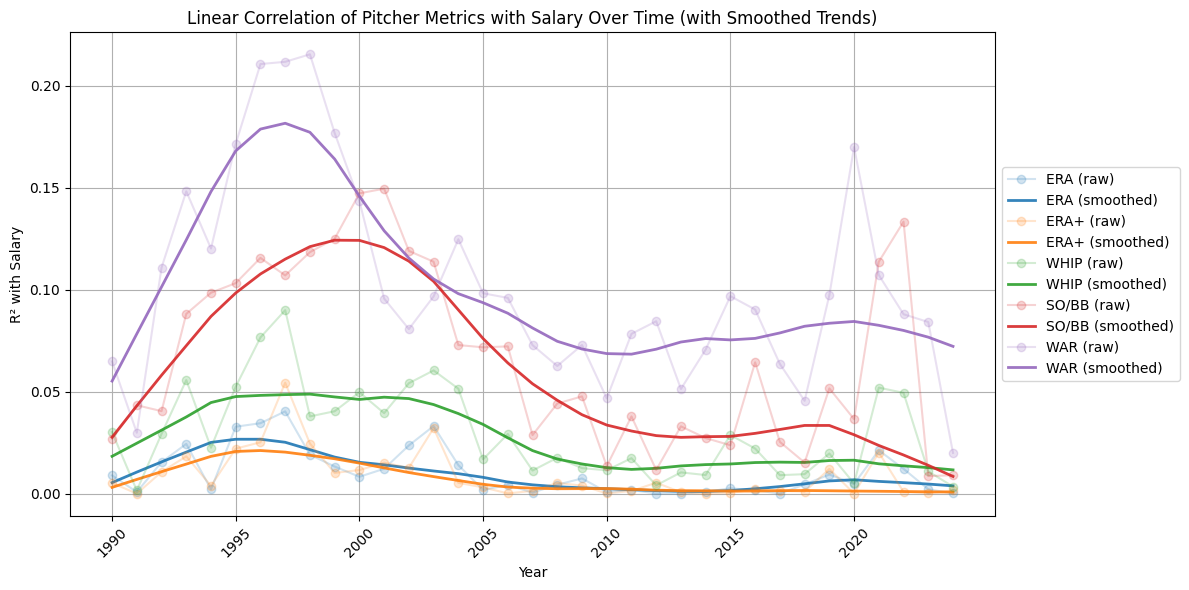

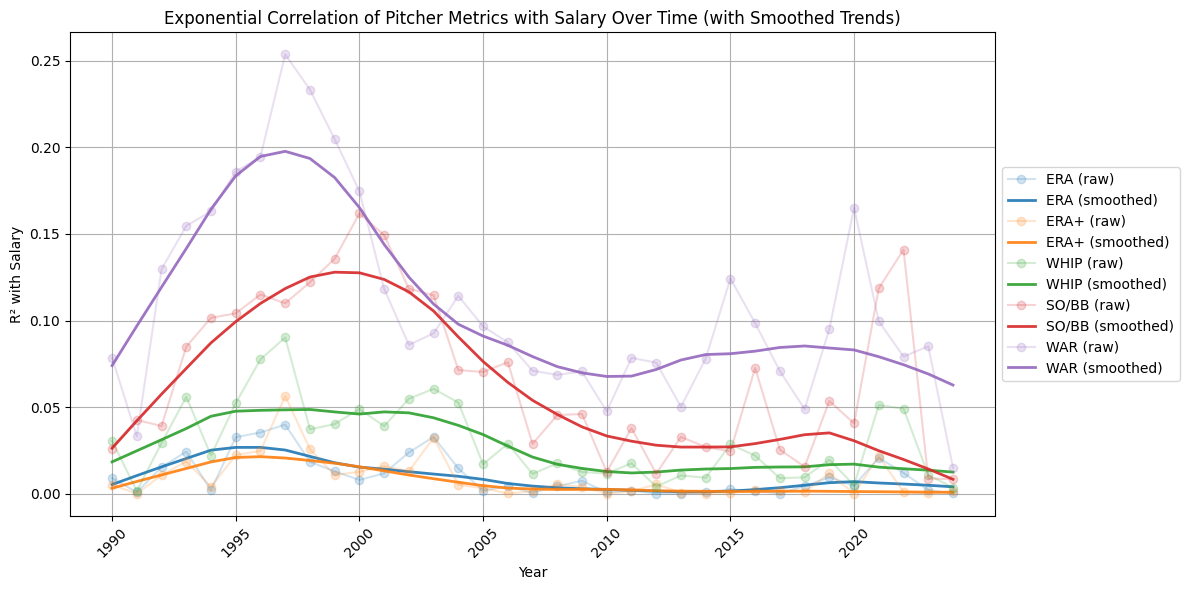

In [14]:
# Fundamental Analysis (Starting Pitchers)

import numpy as np
import statsmodels.api as sm
import scipy.stats as sps
import scipy.optimize as spo
import matplotlib.pyplot as plt

def get_r_squared(salary_list: list[float], metric: list[float|int]) -> tuple[float, float]:
    "return (Linear_R^2, Exponential_R^2)"

    def exponential(x, a, b):
        return a * np.exp(b * x)
    
    if len(salary_list) != len(metric):
        raise ValueError("Expected lists to be of same size")
    
    salary_arr = np.array(salary_list) / 1_000_000  # scale salaries to millions
    metric_arr = np.array(metric)

    mask = (salary_arr != 0) & (metric_arr != 0)
    x = salary_arr[mask]
    y = metric_arr[mask]

    # Linear r
    r_linear = sps.linregress(x, y).rvalue 

    # Exponential R^2
    popt, _ = spo.curve_fit(exponential, x, y, p0=(1, 0.01))
    y_pred_exp = exponential(x, *popt)
    ss_resid = np.sum((y - y_pred_exp)**2)
    ss_total = np.sum((y - np.mean(y))**2)
    r2_exp = 1 - ss_resid / ss_total

    return r_linear**2, r2_exp

def get_pitcher_analysis(pitcher_list):
    # (2024	7000000.0	4.4	91.0	1.445	1.46	0.1)
    # year,   salary,    ERA ,  ERA+,  WHIP,  SO/BB,  WAR
    if not pitcher_list:
        raise ValueError("Must contain at least one pitcher")
    
    # Extract year
    year = pitcher_list[0][0]
    output = {'year': year}
    
    # Extract salary list
    salary_list = [row[1] for row in pitcher_list]
    
    # Map of metric name -> column index in tuple
    metrics = {
    'ERA': 2,
    'ERA+': 3,
    'WHIP': 4,
    'SO/BB': 5,
    'WAR': 6
}
    
    # Compute R^2 for each metric
    for metric_name, idx in metrics.items():
        metric_list = [row[idx] for row in pitcher_list]
        output[metric_name] = get_r_squared(salary_list, metric_list)
    
    return output

# Metric Gathering

pitcher_query = '''
SELECT sal.year,
       sal.salary,
       sp.era,
       sp.era_plus,
       sp.whip,
       sp.so_to_bb,
       vp.war
FROM salary sal
LEFT JOIN standard_pitching sp
    ON sal.composite_id = sp.composite_id
LEFT JOIN value_pitching vp
    ON sal.composite_id = vp.composite_id
WHERE sal.year IS NOT NULL
  AND sal.salary IS NOT NULL
  AND (sp.games >= 20 OR sp.innings_pitched >= 50)
  AND sp.era IS NOT NULL
  AND sp.era_plus IS NOT NULL
  AND sp.whip IS NOT NULL
  AND sp.so_to_bb IS NOT NULL
  AND vp.war IS NOT NULL
  AND sal.year = ?

'''




START_YEAR = 1990
END_YEAR = 2024
cursor = conn.cursor()
years = [(year,) for year in range(START_YEAR, END_YEAR + 1)]
pitcher_data = {}

for year in years:
    cursor.execute(pitcher_query, year)
    pitcher_data[year[0]] = cursor.fetchall()

results = {}
for year in pitcher_data:
    results[year] = get_pitcher_analysis(pitcher_data[year])

# Extract years
years = sorted(results.keys())

# Metrics to track
metrics = ["ERA" ,  "ERA+",  "WHIP",  "SO/BB",  "WAR"]

# Linear
r2_over_time = {metric: [] for metric in metrics}
for year in years:
    year_data = results[year]
    for metric in metrics:
        r2_over_time[metric].append(year_data[metric][0])  # linear R²

# Plot
plt.figure(figsize=(12, 6))

for metric in metrics:
    # Raw values
    raw_line, = plt.plot(years, r2_over_time[metric], marker='o', alpha=0.2, label=f'{metric} (raw)')
    
    # Smoothed trend using LOWESS with same color, higher opacity
    smoothed = sm.nonparametric.lowess(r2_over_time[metric], years, frac=0.3)
    plt.plot(smoothed[:, 0], smoothed[:, 1], color=raw_line.get_color(), linewidth=2, alpha=0.9, label=f'{metric} (smoothed)')

plt.xlabel('Year')
plt.ylabel('R² with Salary')
plt.title('Linear Correlation of Pitcher Metrics with Salary Over Time (with Smoothed Trends)')

# Show x-ticks only for every 5th year
plt.xticks([year for year in years if year % 5 == 0], rotation=45)

# Push legend off to the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(True)
plt.tight_layout()
plt.show()

# Exponential
r2_over_time = {metric: [] for metric in metrics}
for year in years:
    year_data = results[year]
    for metric in metrics:
        r2_over_time[metric].append(year_data[metric][1])  # Exponential R²

# Plot
plt.figure(figsize=(12, 6))

for metric in metrics:
    # Raw values
    raw_line, = plt.plot(years, r2_over_time[metric], marker='o', alpha=0.2, label=f'{metric} (raw)')
    
    # Smoothed trend using LOWESS with same color, higher opacity
    smoothed = sm.nonparametric.lowess(r2_over_time[metric], years, frac=0.3)
    plt.plot(smoothed[:, 0], smoothed[:, 1], color=raw_line.get_color(), linewidth=2, alpha=0.9, label=f'{metric} (smoothed)')

plt.xlabel('Year')
plt.ylabel('R² with Salary')
plt.title('Exponential Correlation of Pitcher Metrics with Salary Over Time (with Smoothed Trends)')

# Show x-ticks only for every 5th year
plt.xticks([year for year in years if year % 5 == 0], rotation=45)

# Push legend off to the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(True)
plt.tight_layout()
plt.show()

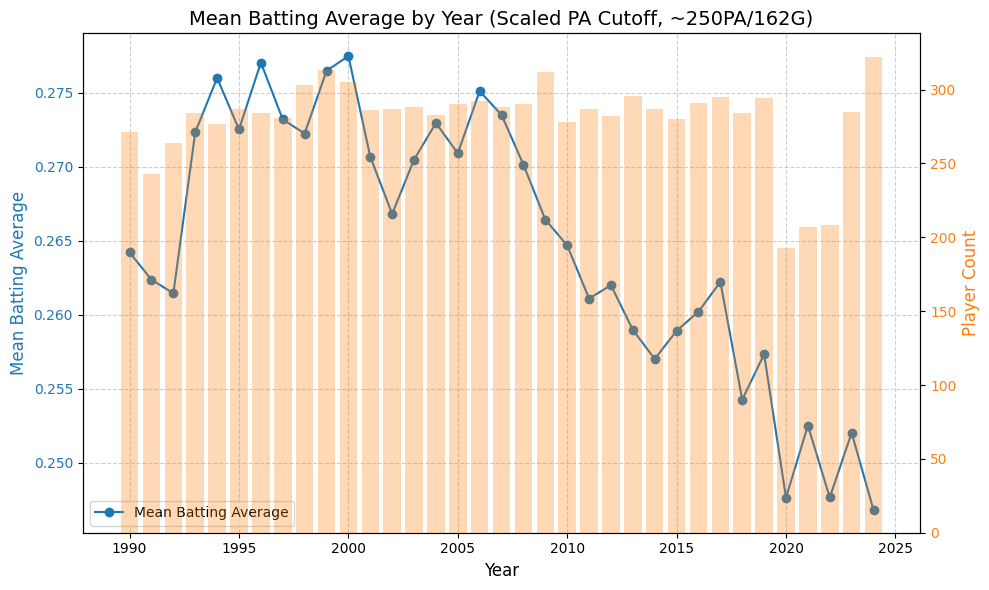

In [16]:
# Mean Batting Average Trend

import matplotlib.pyplot as plt
import numpy as np

query = '''WITH season_length AS (
    SELECT sal.year, MAX(sb.games) AS games
    FROM salary sal
    LEFT JOIN standard_batting sb
        ON sal.composite_id = sb.composite_id
    GROUP BY sal.year
)
SELECT sal.year,
       AVG(sb.batting_average) AS Mean_BA,
       AVG(sb.ops) AS Mean_OPS,
       COUNT(*) AS Player_Count
FROM salary sal
LEFT JOIN standard_batting sb
    ON sal.composite_id = sb.composite_id
    
LEFT JOIN season_length sl
    ON sal.year = sl.year
WHERE sb.plate_appearances > (sl.games * 1.5) -- Making sure we adjust for short seasons
GROUP BY sal.year;'''

cursor = conn.cursor()

cursor.execute(query)
rows = cursor.fetchall()
years = [row[0] for row in rows]
avg_ba = [row[1] for row in rows]
avg_ops = [row[2] for row in rows]
player_count = [row[3] for row in rows]

cursor.execute(query)
rows = cursor.fetchall()
years = [row[0] for row in rows]
avg_ba = [row[1] for row in rows]
avg_ops = [row[2] for row in rows]
player_count = [row[3] for row in rows]

slope, intercept = np.polyfit(years, avg_ba, 1)
trend_line = [slope * year + intercept for year in years]

fig, ax1 = plt.subplots(figsize=(10,6))

# Player count bars — draw first
ax2 = ax1.twinx()
ax2.bar(years, player_count, alpha=0.3, color='tab:orange', label='Player Count', zorder=1)
ax2.set_ylabel("Player Count", color='tab:orange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Batting average line — draw on top
ax1.plot(years, avg_ba, marker='o', color='tab:blue', label='Mean Batting Average', zorder=2)

# Linear trend line
# ax1.plot(years, trend_line, linestyle=':', color='black', label=f'Trend: slope={slope:.4f}', zorder=3,)

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Mean Batting Average", color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.6)

# Title and legend
plt.title("Mean Batting Average by Year (Scaled PA Cutoff, ~250PA/162G)", fontsize=14)
ax1.legend(loc='lower left')
fig.tight_layout()
plt.show()


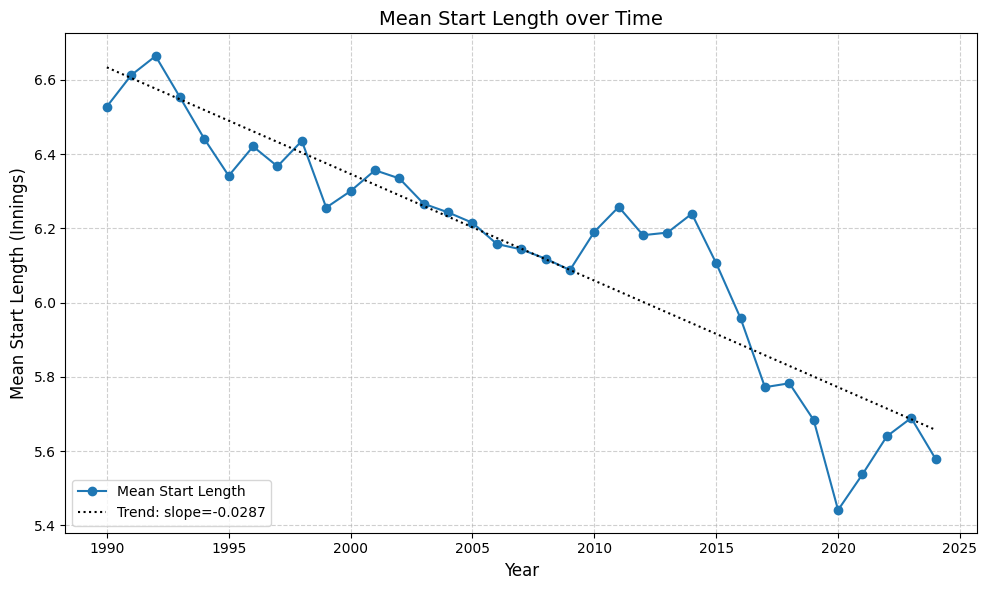

In [32]:
# Starting pitcher appearance length

import matplotlib.pyplot as plt
import numpy as np

query = '''SELECT year,
	all_innings_pitched / all_games_pitched as average_innings_per_game
FROM (
	SELECT sal.year, 
		SUM(sp.innings_pitched) as all_innings_pitched,
		SUM(sp.games_started) as all_games_pitched
	FROM salary sal LEFT JOIN standard_pitching sp
		ON sal.composite_id = sp.composite_id
	WHERE sp.games_started >= 10
	GROUP BY sal.year) as sub
    '''

cursor = conn.cursor()
cursor.execute(query)

# Year		avg_innings_game
data = cursor.fetchall()

years = [row[0] for row in data]
averages = [row[1] for row in data]

slope, intercept = np.polyfit(years, averages, 1)
trend_line = [slope * year + intercept for year in years]

fig, ax1 = plt.subplots(figsize=(10,6))

# Batting average line — draw on top
ax1.plot(years, averages, marker='o', color='tab:blue', label='Mean Start Length', zorder=2)

# Linear trend line
ax1.plot(years, trend_line, linestyle=':', color='black', label=f'Trend: slope={slope:.4f}', zorder=3,)

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Mean Start Length (Innings)", color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, linestyle='--', alpha=0.6)

# Title and legend
plt.title("Mean Start Length over Time", fontsize=14)
ax1.legend(loc='lower left')
fig.tight_layout()
plt.show()


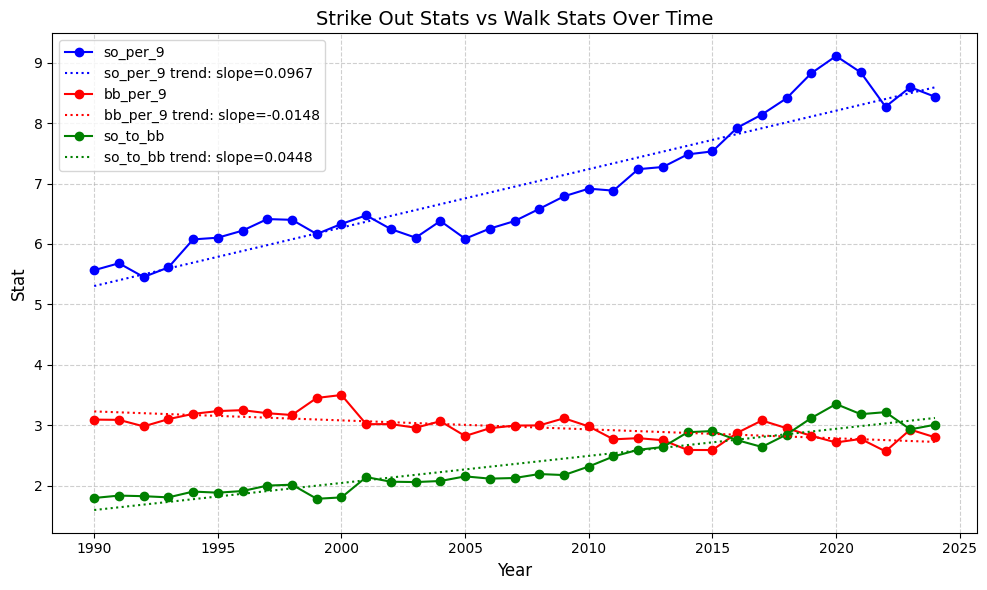

In [43]:
# Strikeouts vs Walks over time

import matplotlib.pyplot as plt
import numpy as np

query = '''SELECT
    sal.year,
    -- Weighted averages
    SUM(sp.so_per_9 * sp.innings_pitched) / SUM(sp.innings_pitched) AS avg_so_per_9,
    SUM(sp.bb_per_9 * sp.innings_pitched) / SUM(sp.innings_pitched) AS avg_bb_per_9,
    -- SO/BB ratio computed from weighted sums
    SUM(sp.so_per_9 * sp.innings_pitched) / NULLIF(SUM(sp.bb_per_9 * sp.innings_pitched), 0) AS avg_so_to_bb
FROM salary sal
LEFT JOIN standard_pitching sp
    ON sal.composite_id = sp.composite_id
WHERE sp.games_started >= 10
GROUP BY sal.year
ORDER BY sal.year;
    '''

cursor = conn.cursor()
cursor.execute(query)

data = cursor.fetchall()

years = [row[0] for row in data]

data = {    
    "so_per_9" : [row[1] for row in data],
    "bb_per_9" : [row[2] for row in data],
    "so_to_bb" : [row[3] for row in data]
}
colors = ["blue", "red", "green"]

fig, ax1 = plt.subplots(figsize=(10,6))

for stat, color in zip(data, colors):
    slope, intercept = np.polyfit(years, data[stat], 1)
    trend_line = [slope * year + intercept for year in years]

    # Batting average line — draw on top
    ax1.plot(years, data[stat], marker='o', color=color, label=stat, zorder=2)

    # Linear trend lines
    ax1.plot(years, trend_line, linestyle=':', color=color, label=f'{stat} trend: slope={slope:.4f}', zorder=3,)



ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Stat", color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, linestyle='--', alpha=0.6)

# Title and legend
plt.title("Strike Out Stats vs Walk Stats Over Time", fontsize=14)
ax1.legend(loc='upper left')
fig.tight_layout()
plt.show()

Fun Queries and Results:

Max Salary by Location:

SELECT printf('%,.02f', MAX(sal.salary)) as Highest_Salary, sal.year, UPPER(SUBSTR(smry.hometown, -2, 2)) as "Country/State", smry.first_name, smry.last_name
FROM salary sal LEFT JOIN summary smry
	ON sal.composite_id = smry.composite_id
WHERE league IS NOT NULL
	AND UPPER(SUBSTR(smry.hometown, -2, 2)) != UPPER(SUBSTR(smry.first_name, -2, 2))
	AND UPPER(SUBSTR(smry.hometown, -2, 2)) GLOB '[A-Z][A-Z]'
GROUP BY SUBSTR(smry.hometown, -2, 2)

Salary Value for Home Runs

SELECT year, printf('%,.02f', AVG(Dollars_Per_HR)) as 'Dollars/HR'
FROM (
SELECT sal.salary, sb.home_runs, sal.salary/sb.home_runs as Dollars_Per_HR, sal.year
FROM salary sal LEFT JOIN standard_batting sb
	ON sal.composite_id = sb.composite_id
WHERE sal.salary/sb.home_runs > 0 
	AND sb.plate_appearances > 100) as data
GROUP BY year